In [2]:
library(rugarch)
library(VineCopula)
library(fGarch) 
library(quantreg)
library(readxl)
library(xts)

Warning message:
"package 'rugarch' was built under R version 4.2.3"
Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Warning message:
"package 'VineCopula' was built under R version 4.2.3"
Warning message:
"package 'fGarch' was built under R version 4.2.3"
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Warning message:
"package 'quantreg' was built under R version 4.2.3"
Loading required package: SparseM


Attaching package: 'SparseM'


The following object is masked from 'package:base':

    backsolve


Warning message:
"package 'readxl' was built under R version 4.2.3"
Warning message:
"package 'xts' was built under R version 4.2.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.2.3"

Attach

In [3]:
#用相对路径读取数据更整洁，代码鲁棒性更强
df <- read_excel("./test.xlsx")
df$日期 <- as.Date(df$日期, format = "%Y-%m-%d")
# 调整为日期格式
ts_df <- xts(df[-1], order.by = df$日期)
date_st <- index(ts_df)
dim(ts_df)
tail(ts_df)

[1] 1678   39

           香蜜湖指数   中国银行   工商银行   交通银行   建设银行   中信银行
2024-04-16 -4.0291639  1.0834342  0.9182801  0.2989539  0.4192878 -1.5015297
2024-04-17  4.2765524  0.4301082  0.5469476  0.8915364  1.5225208  9.5172638
2024-04-18 -0.3160644  0.6417134  0.3629768  1.3225762  0.2743486  8.6896744
2024-04-19 -1.6792034  0.6376217  0.5420067  0.7272759  0.6825965 -8.6896744
2024-04-22  0.3443545 -1.2793351 -1.2692827 -0.8733680 -0.6825965 -3.4993074
2024-04-23  0.5518959  0.0000000  0.3642991  1.1628038  0.1368926  0.2844952
              平安银行   浦发银行    招商银行   华夏银行    中信证券   海通证券
2024-04-16 -0.09722898 -0.5494519 -0.24397694 -0.3007521 -0.62199805 -1.6571444
2024-04-17  3.25387558  1.0959014  1.66544349  1.9389123  2.63099419  1.9096697
2024-04-18  1.68071183 -0.1363327  1.04556591  0.8823587  0.60589555  1.6260521
2024-04-19 -1.02374091  0.1363327 -0.08919281  0.2923979 -0.44028690 -0.2484473
2024-04-22 -1.79334679 -0.6835297 -0.83632507 -0.5856532  0.82395413  0.6199648
2024-04-23  0.38022859  0.6835

In [4]:
#ARMA egarch model
uspec <- ugarchspec(mean.model = list(armaOrder = c(1,2), include.mean = TRUE),
variance.model = list(model = "eGARCH"), 
distribution.model = "sstd")
#用刚刚定义的模型拟合各列数据
f1 <- function(x) {ugarchfit(uspec, data = x)}
fit <- apply(ts_df,2, f1)

In [5]:
# 保存ugarchfit对象，这样就不用重复跑了
saveRDS(fit, file = "garch_model.rds")
#读取模型
fit <- readRDS(file = "garch_model.rds")

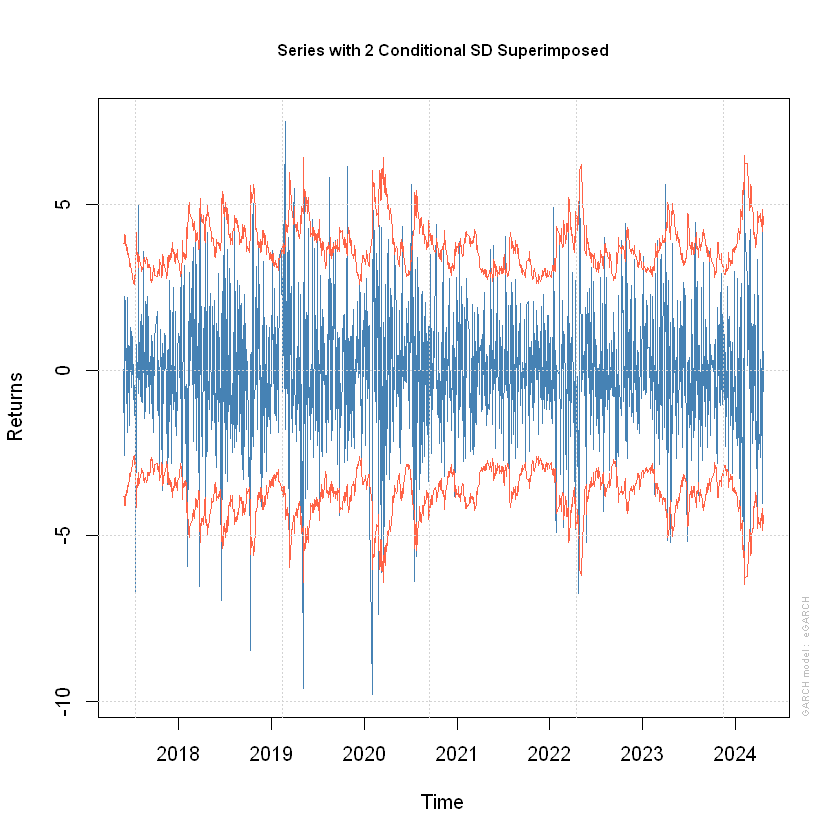

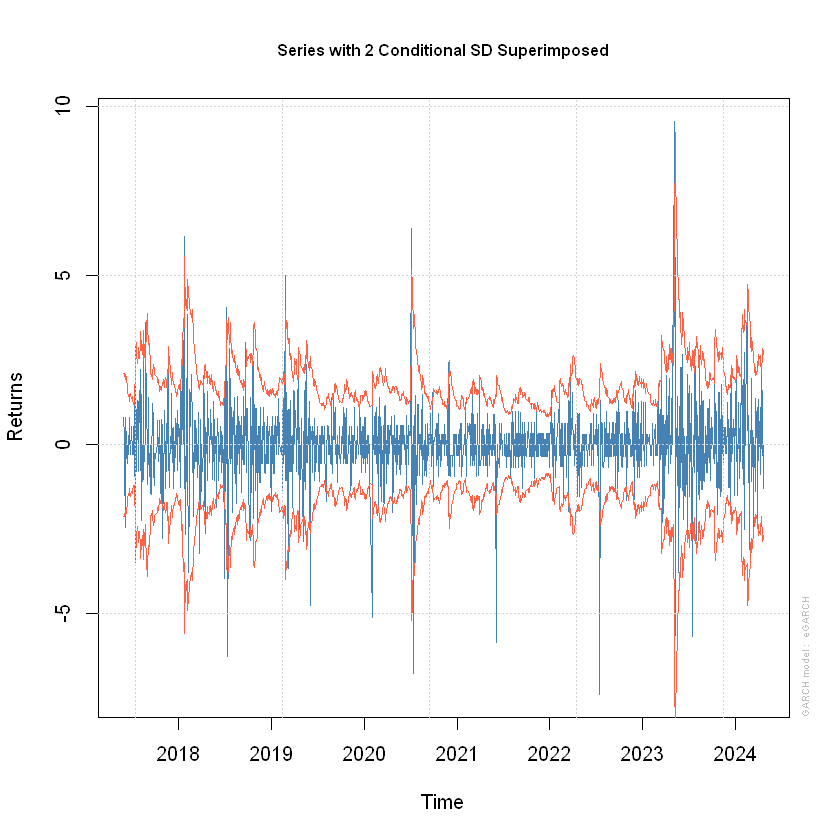

In [6]:
#绘图（先以香蜜湖指数和中国银行为例）
plot(fit$香蜜湖指数,which=1)
plot(fit$中国银行,which=1)

In [7]:
fintech_res <- residuals(fit$香蜜湖指数)
index(fintech_res) <- date_st
cbank_res <- residuals(fit$中国银行)
index(cbank_res) <- date_st

In [8]:
##process of Returns of the 中国银行
## <-记得加空格，代码规范
spec_cbank <- uspec
setfixed(spec_cbank) <- as.list(coef(fit$中国银行))

filt_cbank <- ugarchfilter(spec_cbank, ts_df$中国银行)

In [9]:
length(cbank_res) == length(sigma(filt_cbank))

[1] TRUE

In [10]:
rrss <- cbind(cbank_res,sigma(filt_cbank),cbank_res/sigma(filt_cbank))
ssss1 <- cbind(ts_df$中国银行,fitted(filt_cbank), cbank_res, sigma(filt_cbank), cbank_res/sigma(filt_cbank))
rrss

              cbank_res sigma.filt_cbank. cbank_res.sigma.filt_cbank.
2017-05-31  0.781207516         1.0622322                 0.735439511
2017-06-01  0.296540028         1.0622322                 0.279166865
2017-06-02 -0.517334369         1.0273611                -0.503556494
2017-06-05 -2.483256917         0.9781536                -2.538718822
2017-06-06  0.080472196         1.0376215                 0.077554482
2017-06-07  0.728605696         0.9734949                 0.748443286
2017-06-08 -0.029844984         1.0149074                -0.029406606
2017-06-09 -0.322765216         0.9429306                -0.342300079
2017-06-12 -0.615227546         0.8925022                -0.689328875
2017-06-13 -0.094365971         0.8616881                -0.109512906
       ...                                                           
2024-04-10  0.199921669         1.2532324                 0.159524822
2024-04-11 -0.434071797         1.1840387                -0.366602710
2024-04-12  0.191142

In [11]:
##process of Returns of the 香蜜湖指数
spec_fintech <- uspec
setfixed(spec_fintech)<-as.list(coef(fit$香蜜湖指数))
filt_fintech <- ugarchfilter(spec_fintech, ts_df$香蜜湖指数)
rrss1 <- cbind(fintech_res,sigma(filt_fintech),fintech_res/sigma(filt_fintech))
ssss2 <- cbind(ts_df$香蜜湖指数,fitted(filt_fintech),fintech_res,sigma(filt_fintech),fintech_res/sigma(filt_fintech))

aaaa<-cbind(fintech_res/sigma(filt_fintech),cbank_res/sigma(filt_cbank))

In [12]:
write.csv(aaaa, "E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv")
ts_df_1<-read.csv('E:\\硕士毕业论文\\Rcode\\cbank_residuals.csv')

In [13]:
##input the redusuals of returns
dim(ts_df_1)
tail(ts_df_1)
tail(aaaa)

[1] 1678    3

,X,fintech_res.sigma.filt_fintech.,cbank_res.sigma.filt_cbank.
,<int>,<dbl>,<dbl>
1673,1673,-1.88005276,0.905572943
1674,1674,1.78924427,0.397092784
1675,1675,-0.04012605,0.541572495
1676,1676,-0.80141927,0.547213474
1677,1677,0.17766124,-0.825137488
1678,1678,0.27698175,-0.001350899


           fintech_res.sigma.filt_fintech. cbank_res.sigma.filt_cbank.
2024-04-16                     -1.88005276                 0.905572943
2024-04-17                      1.78924427                 0.397092784
2024-04-18                     -0.04012605                 0.541572495
2024-04-19                     -0.80141927                 0.547213474
2024-04-22                      0.17766124                -0.825137488
2024-04-23                      0.27698175                -0.001350899

In [18]:
# 检查数据框的列名
print(names(ts_df_1))


[1] "X"                               "fintech_res.sigma.filt_fintech."
[3] "cbank_res.sigma.filt_cbank."    


In [22]:
o <- order(ts_df_1$fintech_res.sigma.filt_fintech.)
rd <- cbind(ts_df_1$fintech_res.sigma.filt_fintech.[o],ts_df_1$cbank_res.sigma.filt_cbank.[o])
x <- rd[,1]
y <- rd[,2]

In [24]:
xml = x
cbank = y
est.xml = as.numeric(sstdFit(xml)$estimate)
est.cbank = as.numeric(sstdFit(cbank)$estimate)


Warning message in sqrt(nu - 2):
"NaNs produced"
Warning message in beta(1/2, nu/2):
"NaNs produced"
Warning message in nlm(f = loglik, p = p, y = x, ...):
"NA/Inf replaced by maximum positive value"
Warning message in log(dsstd(y, x[1], x[2], x[3], x[4])):
"NaNs produced"
Warning message in nlm(f = loglik, p = p, y = x, ...):
"NA/Inf replaced by maximum positive value"


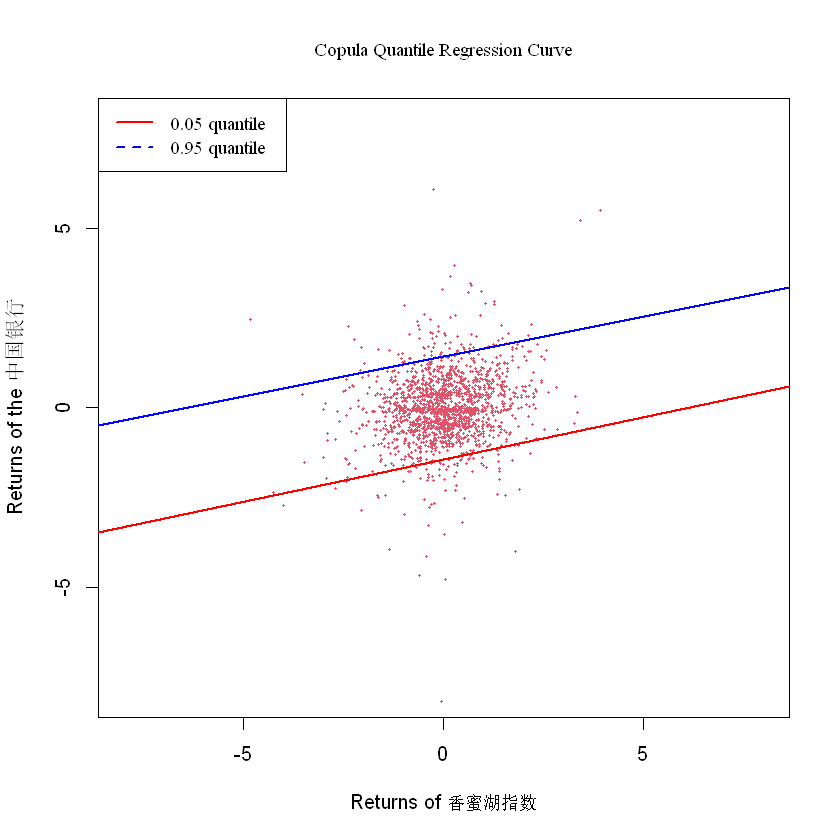

In [32]:

rq05 <- rq(y ~ x, tau = 0.05, data = Dat)  # 0.05分位数回归
rq95 <- rq(y ~ x, tau = 0.95, data = Dat)  # 0.95分位数回归
# 绘制基础图形
plot(x, y, col = 2, cex = 0.5, pch = 20, xlim = c(-8, 8), ylim = c(-8, 8),
     main = 'Copula Quantile Regression Curve', font.main = 6, cex.main = 0.95,
     xlab = 'Returns of 香蜜湖指数', ylab = 'Returns of the 中国银行')

# 添加分位数回归线
abline(rq05, col = "red", lwd = 2)  # 0.05分位数线
abline(rq95, col = "blue", lwd = 2)  # 0.95分位数线

# 添加图例
legend('topleft', c("0.05 quantile", "0.95 quantile"), col = c("red", "blue"),  
       lty = c(1, 2), lwd = c(2, 2), cex = 0.95, text.font = 6)
